# A step-by-step illustration of the algorithm

**This script uses the riversand v1.2.2**

This notebook illustrates the calculations that are performed by the functions `.process_single_catchment()` and `.process_multi_catchment()` step by step. Use this notebook for a better understanding of the algorithm or if you want to develop your own customized script. **The workflow outlined in `quickstart.ipynb` is suitable for most applications, and an understanding of this notebook is not necessary.**

This script uses the example datasets in the folder `test_data`.

# 1. Import data
The coloring in this image represents a (hypothetical) distribution of quartz-bearing (blue) and quartz-free (red) lithologies. The shapefile has 8 polygons (red outlines); we will be using the polygon in the western part of the map (yellow outline).  
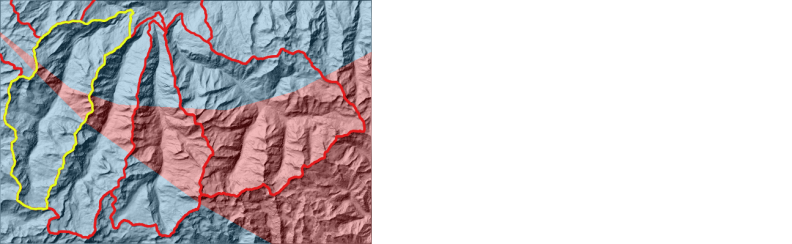

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import riversand
from riversand.params import Params
units = Params.units

In [2]:
# create a new 'Riversand' object
rv = riversand.Riversand()
rv.set_path_to_data('test_data')

# add raster data
rv.add_raster('dem_utm_35m.tif', dtype='elevation')
rv.add_raster('toposhielding_35m.tif', dtype='shielding') # optional
rv.add_raster('quartz_35m.tif', dtype='quartz') # optional

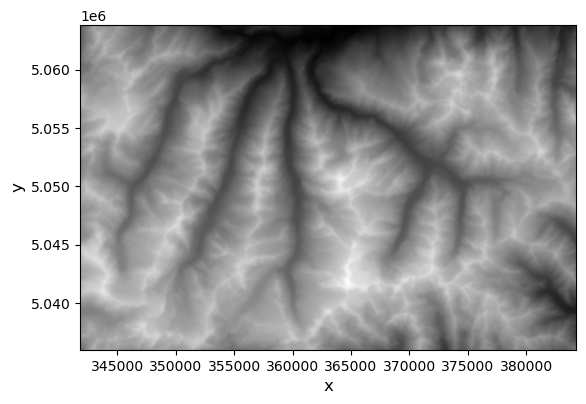

In [3]:
# plot raster data
riversand.plot_raster(rv,
                      dtype='elevation', # plot the shielding raster
                      fname='show')      # display; other options are 'jpg' or 'png' to save the image

In [4]:
# add sample data
rv.add_samples({'N':2.0e4, 'delN': 6.0e2, 'nuclide': 'Be-10'})
rv.add_samples({'N':1.2e5, 'delN': 3.6e3, 'nuclide': 'Al-26'}, add=True)
rv.add_samples({'N':2.0e4, 'delN': 3.0e3, 'nuclide': 'Be-10'}, add=True)
# alternatively, to read from spreadsheet: rv.add_samples('file_name.xlsx')
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [5]:
# add catchment polygons
rv.add_catchments('test_multi_catchment.shp')
rv.set_cid('name')
rv.catchments.get_names()

['DB02', 'DB03', 'DB04', 'DB05', 'DB12', 'DB12', 'DB17', 'DB19']

In [6]:
# all samples in this example are named 'Test', there are no matches with the shapefile polygons
rv.validate()


Raster data valid
Sample data valid
Catchment data valid

Valid catchments / samples:
   No matches found


# 2. Catchment processing
The function `.process_multi_catchment()` matches catchment names to sample names but here we will select the desired catchment manually.

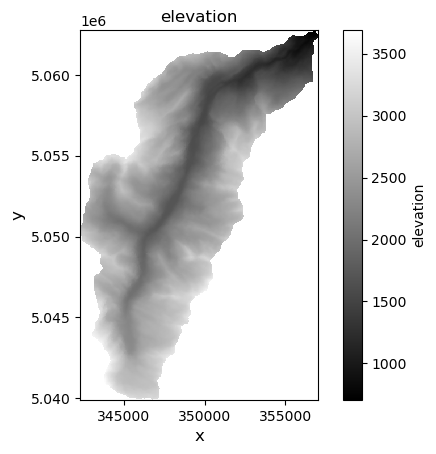

In [7]:
# clip the desired catchment, which happens to be the number n=5 (trial and error...)
clips = rv.clip_all_rasters(n=5)
riversand.plot_clipped_raster(clips,
                              dtype='elevation',
                              fname='show')      # display; other options are 'jpg' or 'png'

In [8]:
# remove the quartz-free areas
clips = riversand.eliminate_quartzfree(clips)

Removed 8.4 % of the catchment as quartz-free


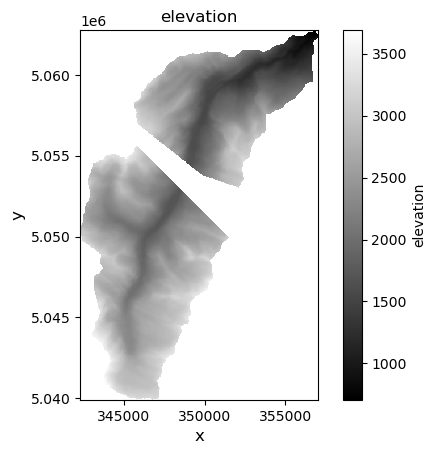

In [9]:
# the quartz-free parts of the catchment are now removed
riversand.plot_clipped_raster(clips,
                              dtype='elevation',
                              fname='show')

The following calculations depend on parameters such as the scaling method or the method for shielding correction. To avoid mixing up parameters we first **define the parameters** and use these definitions in the following function calls.

In [10]:
# define parameters for the calculation
bins = 100              # bin size in meters
scaling = 'LSDn'        # 'St', 'Lm' or 'LSDn'
shielding = 'topo'      # 'topo', 'sample' or numeric
unit = 'mm/kyr'         # for plotting only; no effect on calculations

In [11]:
# compute elevation statistics
topostats, summary = riversand.get_topostats(clips, bins=bins, centroid='from_clipped')
topostats.head()

,bin,elevation,shielding,area,lat,long,wt
0,700.0,749.315002,0.943678,0.245000,45.607522,7.054166,0.001690
1,800.0,859.946350,0.942219,0.388325,45.607522,7.054166,0.002678
2,900.0,947.437195,0.942153,0.711725,45.607522,7.054166,0.004909
3,1000.0,1052.943848,0.932430,0.632100,45.607522,7.054166,0.004360
4,1100.0,1154.039551,0.926303,1.084125,45.607522,7.054166,0.007478


The variable `summary` has some statistics of the clipped catchment including the 35, 50 and 65 percentile elevations and the centroid latitude and longitude (projected coordinates; note that these depend on the extent of the quartz-corrected raster and will be different for the same catchment depending on whether the quartz-free areas are removed). The statistics from `summary` are used to estimate minimum and maximum erosion rates for an optimized determination of the catchmentwide erosion rate. 

In [12]:
summary

{'elevLo': 2274.0,
 'elev50': 2484.0,
 'elevHi': 2688.0,
 'lat': 45.60752151115545,
 'long': 7.054166221307744,
 'areakm2': 144.98119999999997,
 'shielding': 0.9313201,
 'quartz': 0.9161506,
 'epsg': 32632}

## First sample: Be-10

In [13]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [14]:
# select a row from the sample data
i = 0 # first row 
sample_data = rv.samples.iloc[i] 

The sample and nuclide data from the variable `sample_data` and topographic parameters from the variable `summary` are used to estimate a probable range of erosion rates based on the catchment hypsometry:

- The function `.get_textline()` generates input for the online erosion rate calculator<br>
(see http://stoneage.hzdr.de/docs/documentation.html#input_format).

- The function `.get_E()` sends the textline to the server and obtains erosion rates for all implemented scaling methods.

- The function `.guess_erates()` generates suitable erosion rate estimates for polynomial fitting.


In [15]:
# minimum estimate from elevation = summary['elevLo']:
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
textline

'Test 45.60752 7.05417 2274.000 std 0.0 2.65 0.93132 0.00000 2010 ; Test Be-10 quartz 20000.0 600.0 07KNSTD ;'

In [16]:
# obtain erosion rates from server:
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
E_Lo

{'St': 0.07440000000000001,
 'Lm': 0.07636603773584906,
 'LSDn': 0.08048301886792453}

In [17]:
# maximum estimate from elevation = summary['elevHi']:
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
E_Hi

{'St': 0.09655094339622641,
 'Lm': 0.09950566037735849,
 'LSDn': 0.10743773584905661}

In [18]:
#%precision 6
# generate suitable initial erosion rates (scaling specific):
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr
erates

array([0.08048302, 0.08526971, 0.09034108, 0.09571408, 0.10140663,
       0.10743774])

In [19]:
# perform the polynomial fitting:
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )

**Results of the polynomial fitting:**

In [20]:
E, delE # erosion rate and uncertainty in cm/yr

(0.09429829891460603, (0.0028034648519748573, 0.0029718884159832953))

In [21]:
NofE # predicted nuclide concentrations for the inital erosion rates determined by the online calculator

E_cmyr
0.08048    23340.664525
0.08527    22064.910471
0.09034    20856.595018
0.09571    19711.411886
0.10140    18623.447796
0.10740    17593.048650
Name: LSDn, dtype: float64

In [22]:
err # error message

[]

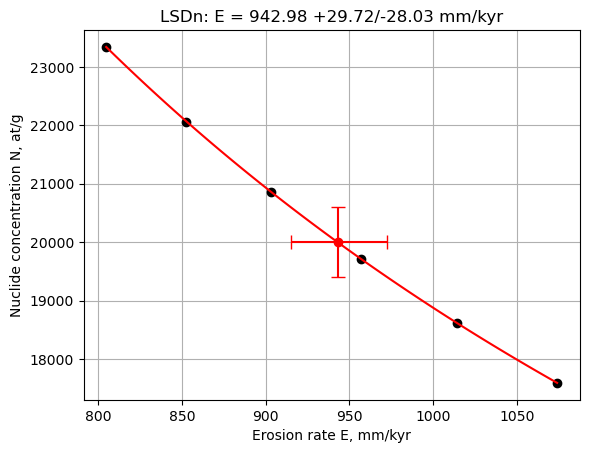

In [23]:
# plot the results
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

- The black points are the erosion rates `erates` sent to the server and the corresponding predicted nuclide concentrations `NofE`.
- The red curve is the polynomial fit to `NofE`
- The red point and vertical error bar are the nuclide concentration of the sample `sample_data['N']` and uncertainty `sample_data['delN']`
- The horizontal error bar is the uncertainty on the erosion rate `delE` resulting from the analytical uncertainty `delN`; it depends on the shape of the function $N(E)$ and is therefore asymmetric. Use the upper value (`delE[1]`) for a more conservative estimate of the analytical uncertainty in `E`.

In [24]:
# pretty print the result E, delE[1]
u = units[unit]
print("{} : {:.1f} +/- {:.1f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Be-10 : 943.0 +/- 29.7 mm/kyr (LSDn)


## Second sample: Al-26

In [25]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [26]:
# select a row from the sample data
i = 1 # second row 
sample_data = rv.samples.iloc[i]

In [27]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

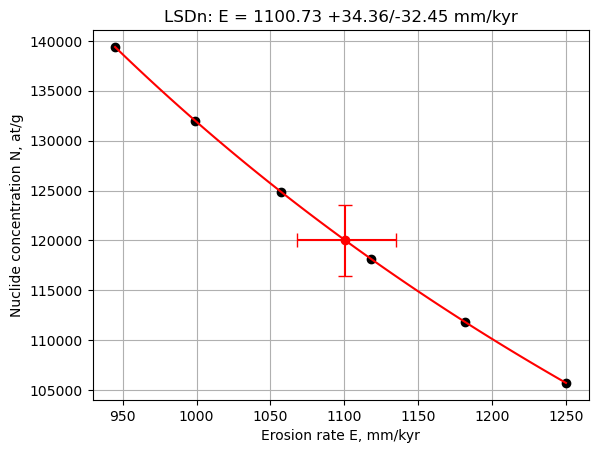

In [28]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [29]:
print("{} : {:.1f} +/- {:.1f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Al-26 : 1100.7 +/- 34.4 mm/kyr (LSDn)


## Third sample: Be-10 with a 5 times higher uncertainty than first sample

In [30]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [31]:
# select a row from the sample data
i = 2 # third row 
sample_data = rv.samples.iloc[i]

In [32]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

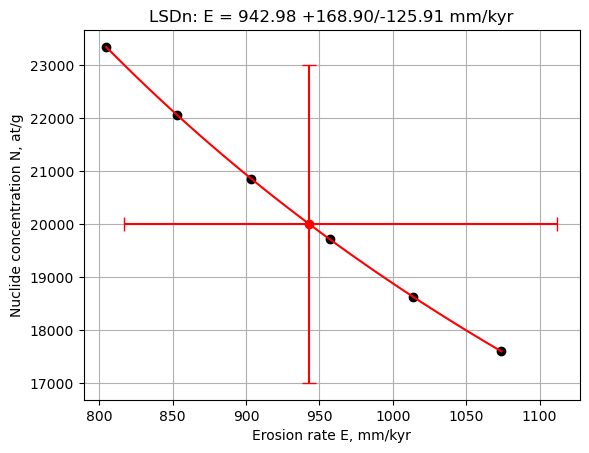

In [33]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [34]:
print("{} : {:.1f} +/- {:.1f} {} ({})".format(sample_data['nuclide'], E*u, delE[1]*u, unit, scaling))

Be-10 : 943.0 +/- 168.9 mm/kyr (LSDn)


# 3. Plotting functions

The plotting functions of `riversand` store output files in a subfolder in the current working directory. By default, this folder is `'plots'`; a different folder can be specified with `riversand.set_outpath('folder_name')`. The folder will be created if it does not exist; any files with the same name will be overwritten without warning. Use `riversand.Params.out_path` to check, which output folder is currently set.

### `riversand.plot_raster(rv)`

Generates a plot of the raster(s) uploaded to the variable `rv`. It has two optional arguments:

- `dtype` is the type of raster to be plotted, i.e. `'elevation'`, `'shielding'` or `'quartz'` (default: `'elevation'`)<br>
- `fname` may have one of the following values (default: `'show'`):
    - `'show'`: show the plot inline
    - `'jpg'` or `'png'`: save the plot under an auto-generated name
    - `'my_custom_name.jpg`: save the plot under a custom name
    
Auto-generated file names are `_Elevation.jpg`, `_Shielding.png` etc.

In [35]:
riversand.set_outpath('my_plots')
riversand.Params.out_path # which folder is currently set?

'my_plots'

In [36]:
riversand.plot_raster(rv, dtype='shielding', fname='custom_name.jpg')

### `riversand.plot_clipped_raster(clips)`

Generates a plot of the clipped catchments (`clips`). It has three optional arguments:

- `dtype` is the type of raster to be plotted, i.e. `'elevation'`, `'shielding'` or `'quartz'` (default: `'elevation'`)<br>
- `c_name` is a catchment name used as prefix for the auto-generated name
- `fname` may have one of the following values (default: `'jpg'`):
    - `'show'`: show the plot inline
    - `'jpg'` or `'png'`: save the plot under an auto-generated name
    - `'my_custom_name.jpg`: save the plot under a custom name

 
Auto-generated file names are `elevation.jpg`, `shielding.png` etc.,<br>
or `Ph-1_elevation.jpg` etc. if the catchment name is specified  with the parameter `c_name='Ph-1'`.

In [37]:
riversand.plot_clipped_raster(clips, dtype='shielding', c_name='Ph-1')

### `riversand.plot_polyfit(E, delE, NofE, sample_data)`

Plots the results of `E, delE, NofE, err = riversand.poly_E_results(sample_data, ...)`. Optional arguments are:

- `unit`: unit of erosion rate used for plotting, e.g. `'mm/yr'` or `'cm/kyr'`; see `riversand.params.units` for valid options
- `fname` may have one of the following values (default: `'jpg'`):
    - `'show'`: show the plot inline
    - `'jpg'` or `'png'`: save the plot under an auto-generated name
    - `'my_custom_name.jpg`: save the plot under a custom name

Auto-generated file names include the sample name and scaling method, e.g. `Test_Lm.jpg` etc.;<br>
a custom sample name can be specified with the parameter `c_name`.

In [38]:
# file name automatically generated from sample_data['name'] and the scaling method used to generate NofE
riversand.plot_polyfit(E, delE, NofE, sample_data, fname='jpg')
sample_data['name'] # what is the name of the current sample?

'Test'

In [39]:
# file name generated from a custom sample name 'Ph-1' and the scaling method used to generate NofE
riversand.plot_polyfit(E, delE, NofE, sample_data, fname='jpg', c_name='Ph-1')

In [40]:
# chosing a custom file name
riversand.plot_polyfit(E, delE, NofE, sample_data, fname='my_choice.jpg')

# Finally:
### Some comments on the choice of initial erosion rates:
The functions `.process_single_catchment()`and `.process_multi_catchment()` optimize the choice of a suitable set of initial erosion rates `erates`. You can customize the initial erosion rates, even though this is generally not necessary or even useful:

In [41]:
sample_data = rv.samples.iloc[0]

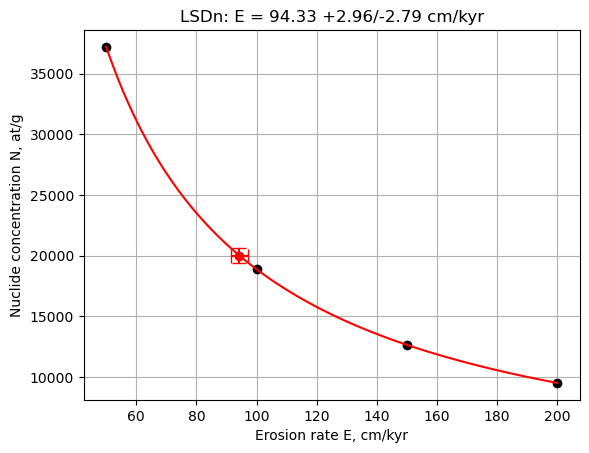

In [42]:
# (1) Custom initial erosion rates:
unit = 'cm/kyr'
erates = [0.05, 0.10, 0.15, 0.20] # cm/yr
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

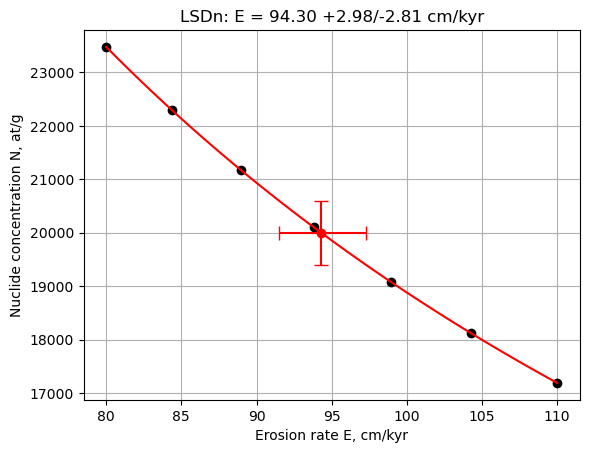

In [43]:
# (2) Using the function .guess_erates() for logarithmically distributed values
erates = riversand.guess_erates(0.08, 0.11, N=7)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

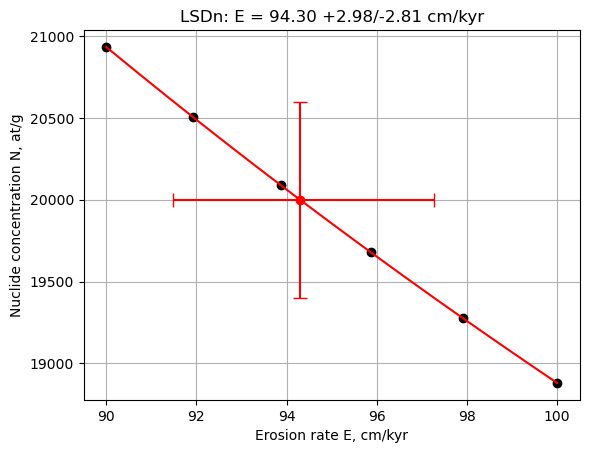

In [44]:
# (3) Using narrower brackets 
erates = riversand.guess_erates(0.09, 0.10, N=6)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [45]:
# (4) Note that you may get error messages for an unsuitable choice of initial erosion rates
erates = riversand.guess_erates(0.08, 0.09, N=6)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
err

['maxE too low']

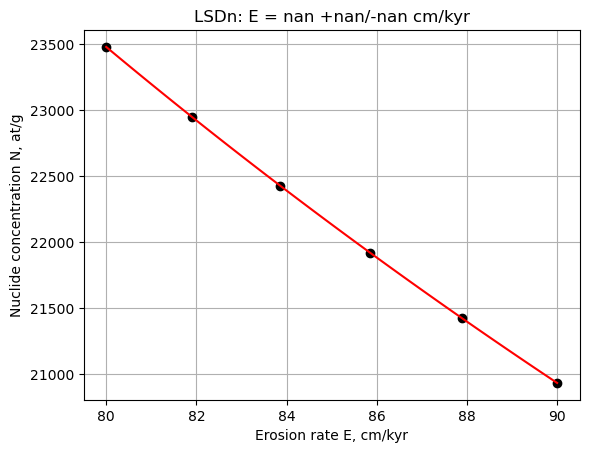

In [46]:
# erosion rate is outside of the range of NofE: nothing much to plot
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

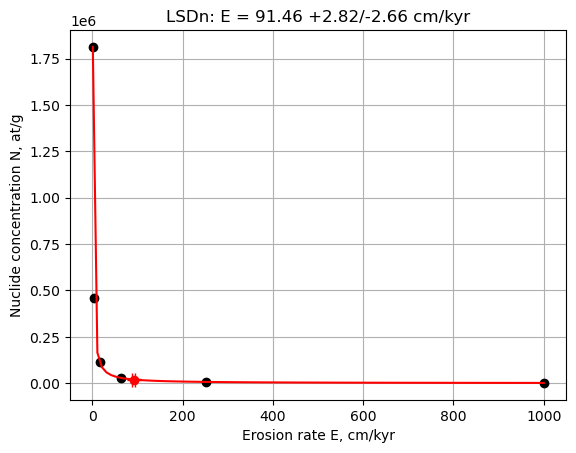

In [47]:
# (5) Unsuitable initial erosion rates may also result in a poor fit of the polynomial function
erates = riversand.guess_erates(0, 1)
E, delE, NofE, err = (riversand.poly_E_results(sample_data, topostats, 
                                               shielding=shielding, erates=erates, scaling=scaling)
                     )
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

#NRMSE = riversand.get_RMSE(NofE)/sample_data['N']

In [48]:
err

['NRMSE = 3.16e-02 suggests a poor fit of the polynomial']

### Extremely high and very low erosion rates
The algorithm becomes unstable for extremely low and extremely high nuclide concentrations; try the following code with concentrations of **N = 100 atoms/gram** or **N = 5E+7 atoms/gram**. It is, of course, highly questionable that such nuclide concentrations reflect a catchmentwide erosion rate...

In [49]:
#extremely low nuclide concentrations:
sample_data = {'N': 5e7, 'delN': 1e6}

# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

unit = 'mm/kyr'
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

RuntimeError: get_E() : sample appears to be saturated